# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# conda install -c conda-forge imbalanced-learn
# https://github.com/scikit-learn-contrib/imbalanced-learn
#from imblearn.under_sampling import RandomUnderSampler

# https://xgboost.readthedocs.io/en/latest/
import xgboost
# https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
# defining scoring strategy:
# https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
# scoring needs to be changed with string, ie : LogisticRegressionCV(cv=10, random_state=0,multi_class='multinomial', scoring="f1_score").fit(samples, labels)
# https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import contextily as ctx
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# 1. Dataset preprocessing

In [5]:
# define datasets
london_vdt_loc = 'datasets/VDT/newvdt202002_london.csv'
birmingham_vdt_loc = 'datasets/VDT/newvdt202002_birmingam.csv'
liverpool_vdt_loc = 'datasets/VDT/newvdt202002_liverpool.csv'

london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

In [3]:
# load 'em
london_vdt_pd = pd.read_csv(london_vdt_loc, index_col=False)
birmingham_vdt_pd = pd.read_csv(birmingham_vdt_loc, index_col=False)
liverpool_vdt_pd = pd.read_csv(liverpool_vdt_loc, index_col=False)
# filter columns we will use
london_vdt_pd = london_vdt_pd.loc[:,london_vdt_pd.columns.str.contains('weighted|lkey')] 
birmingham_vdt_pd = birmingham_vdt_pd.loc[:,birmingham_vdt_pd.columns.str.contains('weighted|lkey')] 
liverpool_vdt_pd = liverpool_vdt_pd.loc[:,liverpool_vdt_pd.columns.str.contains('weighted|lkey')] 

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)

In [4]:
london_vdt_pd.drop(['weighted_unique_users', 'weighted_total_volume'],axis=1, inplace=True)
birmingham_vdt_pd.drop(['weighted_unique_users', 'weighted_total_volume'],axis=1, inplace=True)
liverpool_vdt_pd.drop(['weighted_unique_users', 'weighted_total_volume'],axis=1, inplace=True)

## 1.1 Drop NA values, monthly ['min', 'max', 'mean', 'std'] for each antenna

In [5]:
london_vdt_pd = london_vdt_pd.dropna().groupby('lkey', as_index=False).agg(['min', 'max', 'mean', 'std']).reset_index()
london_vdt_pd.columns = ['lkey'] + ['_'.join(col) for col in london_vdt_pd.columns[1:]]

birmingham_vdt_pd = birmingham_vdt_pd.dropna().groupby('lkey', as_index=False).agg(['min', 'max', 'mean', 'std']).reset_index()
birmingham_vdt_pd.columns = ['lkey'] + ['_'.join(col) for col in birmingham_vdt_pd.columns[1:]]

liverpool_vdt_pd = liverpool_vdt_pd.dropna().groupby('lkey', as_index=False).agg(['min', 'max', 'mean', 'std']).reset_index()
liverpool_vdt_pd.columns = ['lkey'] + ['_'.join(col) for col in liverpool_vdt_pd.columns[1:]]

## 1.2 Join with IMD info, drop additional columns and dropna rows

In [6]:
london_vdt_pd = london_vdt_pd.merge(london_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey','generation', 'geometry', 'geometry_voronoi']).dropna()
birmingham_vdt_pd = birmingham_vdt_pd.merge(birmingham_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey', 'generation', 'geometry', 'geometry_voronoi']).dropna()
liverpool_vdt_pd = liverpool_vdt_pd.merge(liverpool_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey', 'generation','geometry', 'geometry_voronoi']).dropna()

## 1.3 StandardScale the dataset

In [7]:
# scale the dataset to get better results, scale everything except LSOA_IMD_decile - i.e. labels
scaler = StandardScaler()

scaler.fit(london_vdt_pd[london_vdt_pd.columns[:-1]])
london_vdt_pd_ml_scaled = pd.DataFrame(scaler.transform(london_vdt_pd[london_vdt_pd.columns[:-1]]),columns=london_vdt_pd.columns[:-1])
london_vdt_pd_ml_scaled['IMDDecil'] = london_vdt_pd['IMDDecil'].values
london_vdt_samples = london_vdt_pd_ml_scaled[london_vdt_pd_ml_scaled.columns[:-1]].values
london_vdt_labels = london_vdt_pd_ml_scaled['IMDDecil'].values

scaler.fit(birmingham_vdt_pd[birmingham_vdt_pd.columns[:-1]])
birmingham_vdt_pd_ml_scaled = pd.DataFrame(scaler.transform(birmingham_vdt_pd[birmingham_vdt_pd.columns[:-1]]),columns=birmingham_vdt_pd.columns[:-1])
birmingham_vdt_pd_ml_scaled['IMDDecil'] = birmingham_vdt_pd['IMDDecil'].values
birmingham_vdt_samples = birmingham_vdt_pd_ml_scaled[birmingham_vdt_pd_ml_scaled.columns[:-1]].values
birmingham_vdt_labels = birmingham_vdt_pd_ml_scaled['IMDDecil'].values

scaler.fit(liverpool_vdt_pd[liverpool_vdt_pd.columns[:-1]])
liverpool_vdt_pd_ml_scaled = pd.DataFrame(scaler.transform(liverpool_vdt_pd[liverpool_vdt_pd.columns[:-1]]),columns=liverpool_vdt_pd.columns[:-1])
liverpool_vdt_pd_ml_scaled['IMDDecil'] = liverpool_vdt_pd['IMDDecil'].values
liverpool_vdt_samples = liverpool_vdt_pd_ml_scaled[liverpool_vdt_pd_ml_scaled.columns[:-1]].values
liverpool_vdt_labels = liverpool_vdt_pd_ml_scaled['IMDDecil'].values

In [11]:
liverpool_vdt_pd_ml_scaled

,weighted_pktloss_perc50_min,weighted_pktloss_perc50_max,weighted_pktloss_perc50_mean,weighted_pktloss_perc50_std,weighted_pktloss_perc10_min,weighted_pktloss_perc10_max,weighted_pktloss_perc10_mean,weighted_pktloss_perc10_std,weighted_pktloss_perc90_min,weighted_pktloss_perc90_max,...,weighted_latency_perc10_std,weighted_latency_perc90_min,weighted_latency_perc90_max,weighted_latency_perc90_mean,weighted_latency_perc90_std,weighted_latency_min,weighted_latency_max,weighted_latency_mean,weighted_latency_std,IMDDecil
0,0.962012,-0.013022,0.284447,-0.130200,0.203897,-0.073448,0.063928,-0.094467,0.013215,1.495539,...,0.287450,2.407257,1.157087,2.890645,1.007115,3.257950,0.379867,1.793560,0.148786,5
1,-0.366519,4.779966,1.876398,3.790462,-0.313313,4.794754,1.983708,3.790527,-1.350203,3.801960,...,0.319954,-0.709793,-0.129784,-0.200104,-0.190383,-0.795468,0.465296,0.481611,0.220877,1
2,-0.366519,0.657680,0.778427,1.038988,-0.313313,0.690830,0.861493,1.057706,-1.350203,-1.498782,...,-0.221296,-0.694406,-0.632822,-0.700404,-0.550027,-0.759519,-0.461845,-0.642761,-0.316742,8
3,-0.366519,0.245451,-0.123134,0.381313,-0.313313,0.280437,-0.059975,0.404490,-1.350203,-2.028857,...,-0.145763,-0.589376,-0.544031,-0.676045,-0.499838,-0.514127,-0.291672,-0.585329,-0.238743,4
4,1.487681,0.565860,1.701295,0.361878,1.720906,0.599419,1.773279,0.354334,-1.125690,-0.826543,...,0.434276,-0.535293,-0.153339,-0.380258,-0.103533,-0.427173,0.109234,-0.109629,0.134016,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,-0.366519,1.076919,1.798720,1.600620,-0.313313,1.108202,1.904316,1.615530,-1.350203,-0.959693,...,0.617678,-0.709793,-0.198620,-0.276891,0.013277,-0.795468,0.048192,0.005189,0.268151,6
1527,5.712359,1.323233,2.982215,0.887206,6.355745,1.353418,3.036186,0.900698,-0.562385,-0.642965,...,-0.098952,-0.601426,-0.531829,-0.575992,-0.451269,-0.557299,-0.346689,-0.489038,-0.236442,5
1528,1.584535,0.099372,0.712349,-0.045211,0.758295,0.029237,0.320839,0.004252,-0.178728,0.738869,...,-0.075493,-0.230682,0.418372,0.635944,0.504146,-0.118229,-0.110244,0.079167,-0.040986,8
1529,-0.313232,1.241634,0.416236,1.117645,-0.291454,1.272183,0.165984,1.028768,-0.882590,1.270626,...,-0.054272,-0.474792,0.183701,0.358861,0.345205,-0.357954,0.002685,0.030460,0.093592,7


In [10]:
#np.savetxt('london_vdt_samples.csv', london_vdt_samples, delimiter=',')
#np.savetxt('birmingham_vdt_samples.csv', birmingham_vdt_samples, delimiter=',')
#np.savetxt('liverpool_vdt_samples.csv', liverpool_vdt_samples, delimiter=',')
#b = np.loadtxt('test1.txt', dtype=int)
london_vdt_samples = np.loadtxt('london_vdt_samples.csv', delimiter=',')
birmingham_vdt_samples = np.loadtxt('birmingham_vdt_samples.csv', delimiter=',')
liverpool_vdt_samples = np.loadtxt('liverpool_vdt_samples.csv', delimiter=',')

# 2. Visual check if there is any trend for any of the measuremnts
I can see only a lower volume/retransmission/pktloss toward hight IMD decile. We concluded this from other results where we show that IMD decile use network less.  
less communication -> less traffic -> less pktloss

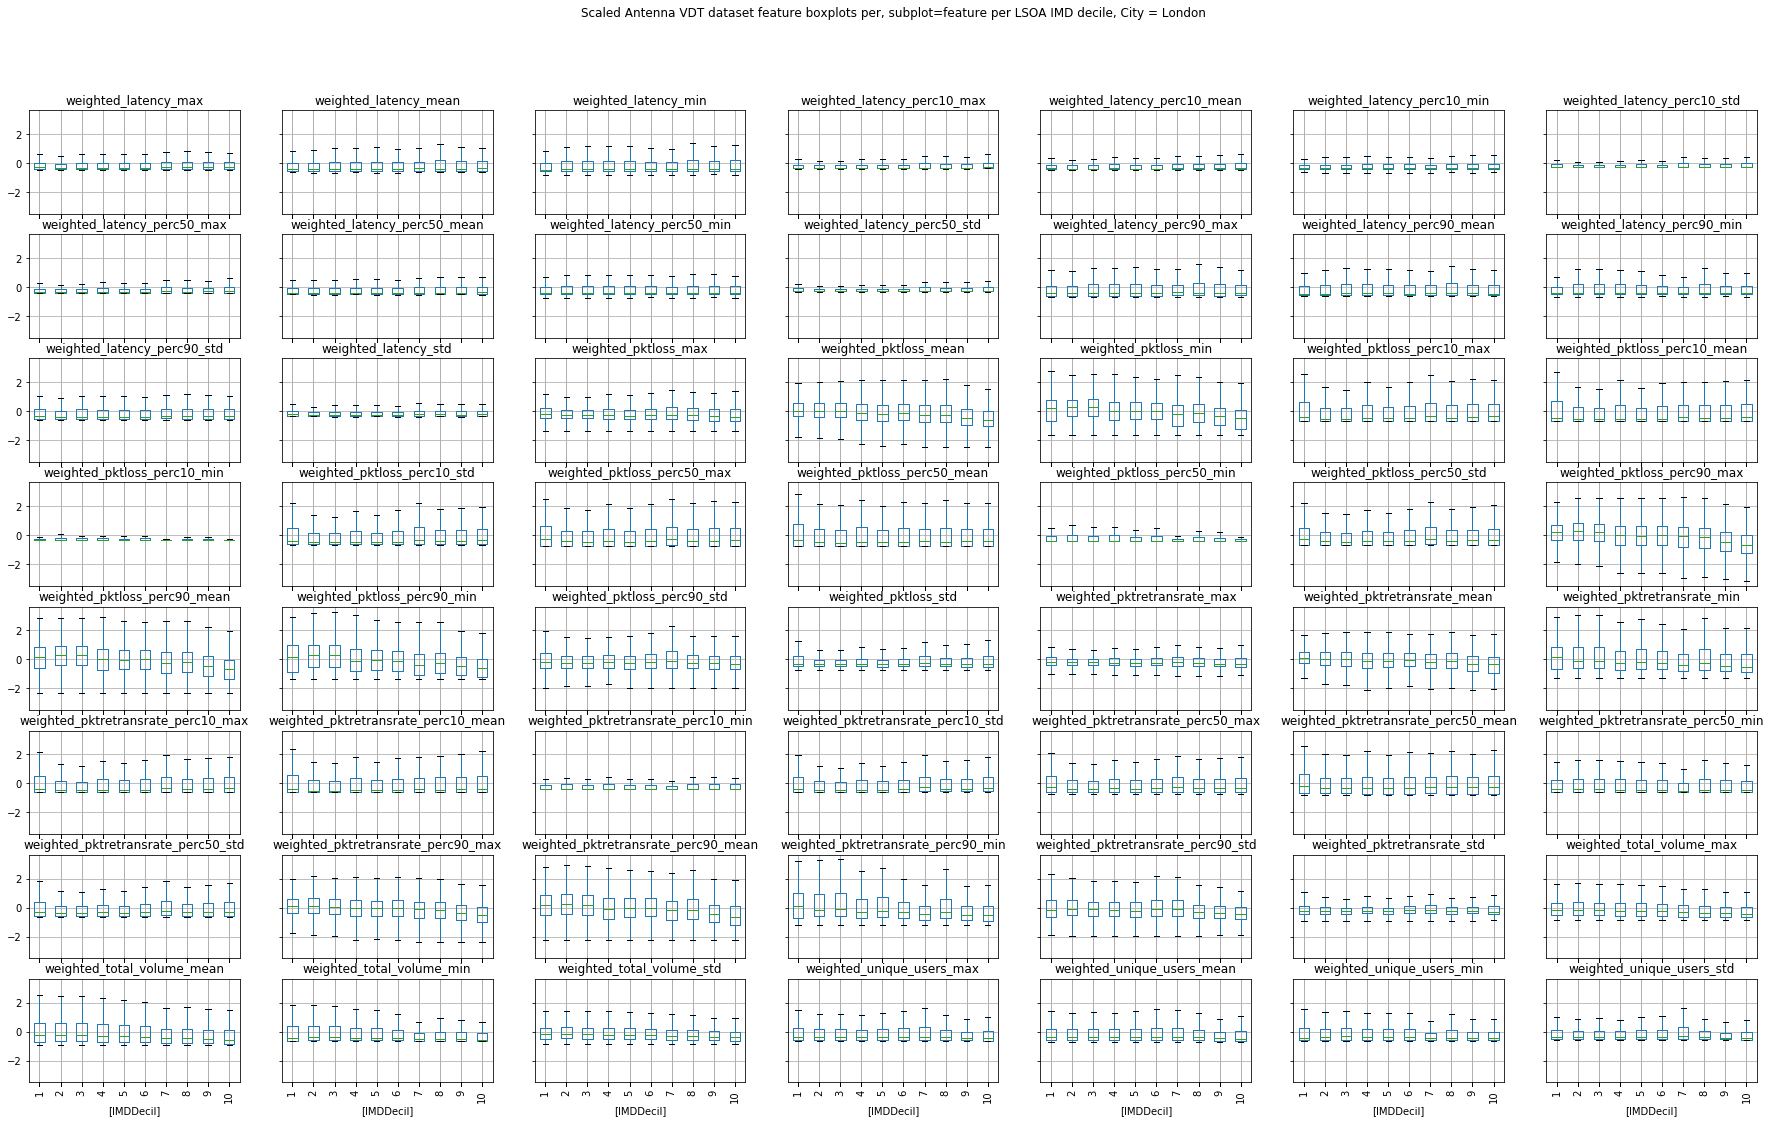

In [56]:
#liverpool_vdt_pd_ml_scaled.groupby(['IMDDecil']).boxplot(,figsize=(30, 18),subplots=False, rot=90, grid=True, layout=(10,1), sharex=True, sharey=False, showfliers=False)
london_vdt_pd_ml_scaled.boxplot(figsize=(30, 18), by='IMDDecil', rot=90, showfliers=False)
title = plt.suptitle("Scaled Antenna VDT dataset feature boxplots per, subplot=feature per LSOA IMD decile, City = London");

# 3. Number of samples (antenna measurements) per IMD decile
The datasets are unbalanced. Only dataset that makes sense is London. We have to either (i) over-sample IMD decile 10 or (ii) under-sample all other deciles. I think under-sampling remaning deciles makes more sense than creating shit load of artificial data for IMD decile 10.
it is also possible to use more complex strategies than randon over/under-sampling:  
https://github.com/scikit-learn-contrib/imbalanced-learn

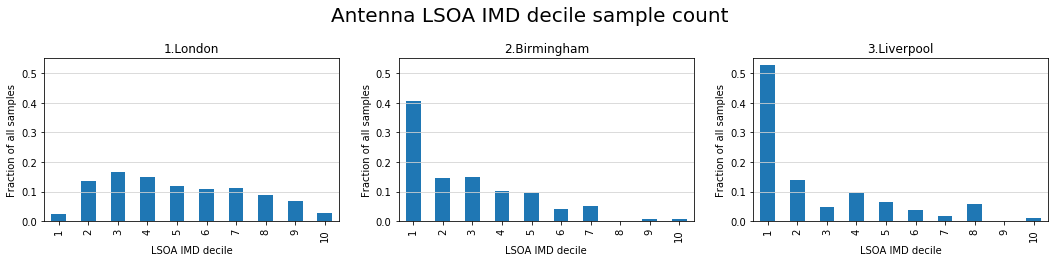

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('Antenna LSOA IMD decile sample count', size=20, y=1.12)

def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    ax.set_ylim([0,0.55])
    ax.set_xlabel('LSOA IMD decile')
    ax.set_ylabel('Fraction of all samples')
    
london_vdt_pd_ml_scaled['IMDDecil'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax[0])
applyPlotStyle(ax[0])
ax[0].set_title('1.London')

birmingham_vdt_pd_ml_scaled['IMDDecil'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax[1])
applyPlotStyle(ax[1])
ax[1].set_title('2.Birmingham')

liverpool_vdt_pd_ml_scaled['IMDDecil'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax[2])
applyPlotStyle(ax[2])
ax[2].set_title('3.Liverpool');

In [58]:
print('CHECK : actual antenna counts in London (without normalization):')
london_vdt_pd_ml_scaled['IMDDecil'].value_counts().sort_index()

CHECK : actual antenna counts in London (without normalization):


1      793
2     4493
3     5392
4     4870
5     3848
6     3535
7     3713
8     2941
9     2278
10     936
Name: IMDDecil, dtype: int64

# 4. Machine learning

## 4.1 Machine learning - Classification

We focus on London dataset as Birmingham and Liverpool are too muc imbalanced to be used for classification.

### 4.1.1 Classification of IMD deciles (10 labels - 1 label per IMD decile)
#### 4.1.1.1 Simple random under-sampling of IMD deciles 2-10

In [65]:
# define undersample strategy
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
# 'not minority' = resample all classes to the size of minority class
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='not minority')
london_vdt_samples_under, london_vdt_labels_under = undersample.fit_resample(london_vdt_samples, london_vdt_labels)

In [60]:
london_vdt_samples_under_train, london_vdt_samples_under_test, london_vdt_labels_under_train, london_vdt_labels_under_test = train_test_split(london_vdt_samples_under, london_vdt_labels_under, test_size=0.1)

In [66]:
# logistic regression
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
# solver = ?
LR_clf_vdt = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# vdt
LRscores_vdt = cross_val_score(LR_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
LR_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
LR_vdt_predicted = LR_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT LR 10CV f1_weighted scores : ' + str(LRscores_vdt))
print('London VDT LR classification report :\n' + str(classification_report(london_vdt_labels_under_test, LR_vdt_predicted)))
print('London VDT LR confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, LR_vdt_predicted)))

# SVM
# about gamma='scale' issue : https://stackoverflow.com/questions/52582796/support-vector-regression-typeerror-must-be-real-number-not-str
SVM_clf_vdt = svm.SVC(decision_function_shape='ovo')
# vdt
SVMscores_vdt = cross_val_score(SVM_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
SVM_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
SVM_vdt_predicted = SVM_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT SVM 10CV f1_weighted scores : ' + str(SVMscores_vdt))
print('London VDT SVM classification report :\n' + str(classification_report(london_vdt_labels_under_test, SVM_vdt_predicted)))
print('London VDT SVM confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, SVM_vdt_predicted)))

# xgboost
XGBOOST_clf_vdt = xgboost.XGBClassifier()
# vdt
XGBOOSTscores_vdt = cross_val_score(XGBOOST_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
XGBOOST_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
XGBOOST_vdt_predicted = XGBOOST_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT XGBOOST 10CV f1_weighted scores : ' + str(XGBOOSTscores_vdt))
print('London VDT XGBOOST classification report :\n' + str(classification_report(london_vdt_labels_under_test, XGBOOST_vdt_predicted)))
print('London VDT XGBOOST confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, XGBOOST_vdt_predicted)))
print('XGBOOST vdt features importances :\n' + str(XGBOOST_clf_vdt.feature_importances_))

#### RESULTS STORE IN MD FORMAT (without non-converging LR warnings)
London VDT LR 10CV f1_weighted scores : 

    [0.1834499  0.17685455 0.17143418 0.1907986  0.16892824 0.19956086 0.19795781 0.16801456 0.15332139 0.17687655]
London VDT LR classification report :

              precision    recall  f1-score   support

           1       0.36      0.48      0.41        82
           2       0.22      0.20      0.21        80
           3       0.16      0.09      0.12        86
           4       0.20      0.17      0.18        78
           5       0.03      0.02      0.02        61
           6       0.15      0.17      0.16        80
           7       0.28      0.29      0.29        76
           8       0.10      0.10      0.10        91
           9       0.11      0.11      0.11        76
          10       0.26      0.41      0.31        83

    accuracy                           0.21       793
    macro avg      0.19      0.20      0.19       793
    weighted avg   0.19      0.21      0.19       793

London VDT LR confusion matrix :

    [[39 13  4  5  3  3  3  6  3  3]
     [13 16 14  9  4  7  3  4  5  5]
     [15 11  8  6  7  9  6  9  6  9]
     [10 10  4 13  2 13  3  4 10  9]
     [ 7  7  3  6  1  8  6  6  5 12]
     [ 9 10  2  7  3 14  8 14  2 11]
     [ 3  3  1  7  0 12 22  8  7 13]
     [ 5  1  6  7  7 12 11  9 17 16]
     [ 3  3  5  2  3  8 11 12  8 21]
     [ 4  0  3  2  3  7  5 14 11 34]]
London VDT SVM 10CV f1_weighted scores : 

    [0.20153256 0.16716974 0.18094708 0.19888673 0.19699043 0.18903206 0.19081645 0.18224286 0.15915701 0.1683845 ]
London VDT SVM classification report :

              precision    recall  f1-score   support

           1       0.40      0.46      0.43        82
           2       0.21      0.23      0.22        80
           3       0.15      0.07      0.10        86
           4       0.14      0.14      0.14        78
           5       0.06      0.05      0.05        61
           6       0.12      0.10      0.11        80
           7       0.32      0.25      0.28        76
           8       0.14      0.11      0.12        91
           9       0.14      0.17      0.15        76
          10       0.25      0.46      0.32        83

    accuracy                           0.21       793
    macro avg      0.19      0.20      0.19       793
    weighted avg   0.20      0.21      0.19       793

London VDT SVM confusion matrix :

    [[38 15  3  7  4  2  2  5  2  4]
     [10 18 13  7  6  7  4  7  5  3]
     [13 13  6  7  8 12  0  8  7 12]
     [11 12  3 11  4  7  3  4  9 14]
     [ 5  5  4 12  3  1  6  7  6 12]
     [ 5 10  5 11  1  8  9  9 11 11]
     [ 3  5  1  6  2 10 19  5  7 18]
     [ 4  3  2  8 11  8  8 10 18 19]
     [ 4  2  3  7  5  6  4  9 13 23]
     [ 2  2  0  3  5  4  5  6 18 38]]
London VDT XGBOOST 10CV f1_weighted scores : 

    [0.17775122 0.20674061 0.21972512 0.1977098  0.18602139 0.21316845 0.22155992 0.17738419 0.1652382  0.18470422]

London VDT XGBOOST classification report :

              precision    recall  f1-score   support

           1       0.41      0.35      0.38        82
           2       0.14      0.14      0.14        80
           3       0.14      0.12      0.13        86
           4       0.10      0.10      0.10        78
           5       0.09      0.13      0.11        61
           6       0.14      0.15      0.15        80
           7       0.27      0.26      0.26        76
           8       0.20      0.14      0.17        91
           9       0.10      0.12      0.11        76
          10       0.29      0.35      0.32        83

    accuracy                           0.19       793
    macro avg      0.19      0.19      0.19       793
    weighted avg   0.19      0.19      0.19       793

London VDT XGBOOST confusion matrix :

    [[29 13 14  9  2  4  5  4  0  2]
     [ 5 11 10 10 15 11  6  4  3  5]
     [12 17 10  6  7 11  2  8  5  8]
     [ 4 12  7  8  9 14  5  3  6 10]
     [ 3  5  4  9  8  5  5  6  7  9]
     [ 6  3  6 13 10 12  9  6 12  3]
     [ 3  2  6  8  5  6 20  7 12  7]
     [ 4  6  1  7 13 12  6 13 16 13]
     [ 3  5  7  9 11  4  7  7  9 14]
     [ 2  2  4  2  5  5 10  7 17 29]]
 
XGBOOST vdt features importances :

    [0.0175559  0.01703185 0.01802919 0.01596189 0.01589568 0.01980334  0.01643864 0.01916142 0.01753999 0.01994848 0.02319316 0.01691371  0.01667256 0.01937116 0.02059078 0.01663987 0.01602063 0.0152166  0.01840713 0.01626005 0.01625397 0.01607869 0.01998846 0.01665597  0.01801855 0.01878574 0.02023085 0.01754559 0.01770974 0.01558603  0.017876   0.01913055 0.01751149 0.01527381 0.01677338 0.01742924  0.01894196 0.01686892 0.01793907 0.0187951  0.01747365 0.01643556  0.01774245 0.01721309 0.0179396  0.01645052 0.0171145  0.01713698  0.01752138 0.01689409 0.01976212 0.02174594 0.01858251 0.01693618  0.02314879 0.0178575 ]

#### 4.1.1.2 Simple random over-sampling of IMD deciles 1-2, 4-10

In [62]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
london_vdt_samples_over, london_vdt_labels_over = oversample.fit_resample(london_vdt_samples, london_vdt_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [63]:
london_vdt_samples_over_train, london_vdt_samples_over_test, london_vdt_labels_over_train, london_vdt_labels_over_test = train_test_split(london_vdt_samples_over, london_vdt_labels_over, test_size=0.1)

In [85]:
# logistic regression
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
# solver = ?
LR_clf_vdt = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# vdt
LRscores_vdt = cross_val_score(LR_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
LR_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
LR_vdt_predicted = LR_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT LR 10CV f1_weighted scores : ' + str(LRscores_vdt))
print('London VDT LR classification report :\n' + str(classification_report(london_vdt_labels_over_test, LR_vdt_predicted)))
print('London VDT LR confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, LR_vdt_predicted)))

# SVM
# about gamma='scale' issue : https://stackoverflow.com/questions/52582796/support-vector-regression-typeerror-must-be-real-number-not-str
SVM_clf_vdt = svm.SVC(decision_function_shape='ovo')
# vdt
SVMscores_vdt = cross_val_score(SVM_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
SVM_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
SVM_vdt_predicted = SVM_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT SVM 10CV f1_weighted scores : ' + str(SVMscores_vdt))
print('London VDT SVM classification report :\n' + str(classification_report(london_vdt_labels_over_test, SVM_vdt_predicted)))
print('London VDT SVM confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, SVM_vdt_predicted)))

# xgboost
XGBOOST_clf_vdt = xgboost.XGBClassifier()
# vdt
XGBOOSTscores_vdt = cross_val_score(XGBOOST_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
XGBOOST_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
XGBOOST_vdt_predicted = XGBOOST_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT XGBOOST 10CV f1_weighted scores : ' + str(XGBOOSTscores_vdt))
print('London VDT XGBOOST classification report :\n' + str(classification_report(london_vdt_labels_over_test, XGBOOST_vdt_predicted)))
print('London VDT XGBOOST confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, XGBOOST_vdt_predicted)))
print('XGBOOST vdt features importances :\n' + str(XGBOOST_clf_vdt.feature_importances_))

#### RESULTS STORED IN MD FORMAT (without non-converging LR warnings)

London VDT LR 10CV f1_weighted scores : 

    [0.18233215 0.13341565 0.14728002 0.12681878 0.14016894 0.11494996 0.11734318 0.13922054 0.14136156 0.15330119]
London VDT LR classification report :

                  precision    recall  f1-score   support

               1       0.21      0.34      0.26       562
               2       0.18      0.24      0.20       553
               3       0.17      0.08      0.11       535
               4       0.16      0.12      0.14       545
               5       0.11      0.03      0.05       546
               6       0.18      0.14      0.16       555
               7       0.20      0.16      0.18       525
               8       0.16      0.11      0.13       541
               9       0.16      0.18      0.17       551
              10       0.19      0.44      0.27       494

        accuracy                           0.18      5407
       macro avg       0.17      0.18      0.17      5407
    weighted avg       0.17      0.18      0.17      5407

London VDT LR confusion matrix :

    [[191 118  35  44  12  35  28  17  21  61]
     [152 131  27  35  18  38  32  30  36  54]
     [116 120  44  54  17  36  28  31  35  54]
     [ 93  84  32  64  20  45  26  36  55  90]
     [ 96  65  30  56  17  56  39  39  66  82]
     [ 73  90  30  28  15  78  48  38  57  98]
     [ 51  35  25  38  18  37  84  38  61 138]
     [ 61  47  20  25  12  52  47  62  79 136]
     [ 39  25  13  35  13  43  47  44  97 195]
     [ 25  23  10  11  14  17  45  44  86 219]]
 
London VDT SVM 10CV f1_weighted scores : 

    [0.21081372 0.16179479 0.18840998 0.16880447 0.14904486 0.13014027 0.13985253 0.15848753 0.17092999 0.18380055]
London VDT SVM classification report :

                  precision    recall  f1-score   support

               1       0.33      0.43      0.38       562
               2       0.18      0.22      0.19       553
               3       0.14      0.07      0.09       535
               4       0.16      0.13      0.15       545
               5       0.17      0.08      0.11       546
               6       0.18      0.19      0.19       555
               7       0.30      0.15      0.20       525
               8       0.21      0.16      0.18       541
               9       0.18      0.21      0.20       551
              10       0.23      0.52      0.32       494

        accuracy                           0.21      5407
       macro avg       0.21      0.22      0.20      5407
    weighted avg       0.21      0.21      0.20      5407

London VDT SVM confusion matrix :

    [[244 123  32  45  13  23  14  16  21  31]
     [116 119  41  58  29  61  11  31  46  41]
     [ 97 122  37  50  34  49  21  33  43  49]
     [ 65  64  55  72  33  61  12  30  68  85]
     [ 69  68  20  60  45  75  31  37  57  84]
     [ 56  69  34  34  40 107  26  40  59  90]
     [ 28  26  16  44  27  58  77  45  64 140]
     [ 27  35  16  39  28  64  25  86  80 141]
     [ 14  28  17  27  15  66  21  49 118 196]
     [ 17  18   4  19   7  20  22  47  85 255]]
London VDT XGBOOST 10CV f1_weighted scores : 

    [0.22780785 0.19807071 0.20612288 0.18153756 0.17258709 0.16714472 0.17762761 0.20024839 0.21362334 0.23492878]
 
London VDT XGBOOST classification report :

                  precision    recall  f1-score   support

               1       0.40      0.61      0.49       562
               2       0.21      0.21      0.21       553
               3       0.19      0.17      0.18       535
               4       0.25      0.11      0.15       545
               5       0.24      0.06      0.10       546
               6       0.19      0.17      0.18       555
               7       0.23      0.21      0.22       525
               8       0.23      0.15      0.18       541
               9       0.26      0.33      0.29       551
              10       0.27      0.63      0.38       494

        accuracy                           0.26      5407
       macro avg       0.25      0.27      0.24      5407
    weighted avg       0.25      0.26      0.24      5407

London VDT XGBOOST confusion matrix :

    [[345  59  45  18  11  16  14  15  17  22]
     [106 117  81  26  17  49  36  24  37  60]
     [ 92  90  90  30  12  48  51  26  50  46]
     [ 82  65  52  59  16  54  37  23  66  91]
     [ 72  61  46  28  35  62  49  37  59  97]
     [ 61  66  54  21  16  92  60  47  67  71]
     [ 34  27  38  17   7  46 111  32  74 139]
     [ 36  44  27  15  17  52  45  80  93 132]
     [ 18  19  23   8  11  40  40  34 181 177]
     [ 13  11   8  10   2  19  31  34  54 312]]
 
XGBOOST vdt features importances :

    [0.0313017  0.02413934 0.02183428 0.0292082  0.         0.03192544
     0.07637774 0.         0.0304318  0.05249074 0.03018742 0.03167293
     0.02265047 0.         0.02446204 0.02884562 0.         0.02201198
     0.03947422 0.         0.0274596  0.03039967 0.         0.02605885
     0.01925856 0.02809073 0.02471512 0.02976209 0.         0.02550377
     0.02347238 0.         0.02782841 0.03251827 0.01911088 0.03815915
     0.03786267 0.02347142 0.02912097 0.03552321 0.         0.02467031]

### 4.1.2 Binary classification scenario 
if IMD_decile>=5 :  IMD_decile=1  
else: IMD_decile=0  
#### 4.1.2.1. Simple random under-sampling of IMD deciles 2-10

In [71]:
# define undersample strategy
# https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
# 'not minority' = resample all classes to the size of minority class
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='not minority')
london_vdt_samples_under, london_vdt_labels_under = undersample.fit_resample(london_vdt_samples, london_vdt_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [73]:
london_vdt_labels_under[london_vdt_labels_under<=5] = 0
london_vdt_labels_under[london_vdt_labels_under>0] = 1

In [75]:
london_vdt_samples_under_train, london_vdt_samples_under_test, london_vdt_labels_under_train, london_vdt_labels_under_test = train_test_split(london_vdt_samples_under, london_vdt_labels_under, test_size=0.1)

In [83]:
# logistic regression
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
# solver = ?
LR_clf_vdt = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# vdt
LRscores_vdt = cross_val_score(LR_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
LR_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
LR_vdt_predicted = LR_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT LR 10CV f1_weighted scores : ' + str(LRscores_vdt))
print('London VDT LR classification report :\n' + str(classification_report(london_vdt_labels_under_test, LR_vdt_predicted)))
print('London VDT LR confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, LR_vdt_predicted)))

# SVM
# about gamma='scale' issue : https://stackoverflow.com/questions/52582796/support-vector-regression-typeerror-must-be-real-number-not-str
SVM_clf_vdt = svm.SVC(decision_function_shape='ovo')
# vdt
SVMscores_vdt = cross_val_score(SVM_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
SVM_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
SVM_vdt_predicted = SVM_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT SVM 10CV f1_weighted scores : ' + str(SVMscores_vdt))
print('London VDT SVM classification report :\n' + str(classification_report(london_vdt_labels_under_test, SVM_vdt_predicted)))
print('London VDT SVM confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, SVM_vdt_predicted)))

# xgboost
XGBOOST_clf_vdt = xgboost.XGBClassifier()
# vdt
XGBOOSTscores_vdt = cross_val_score(XGBOOST_clf_vdt, london_vdt_samples_under, london_vdt_labels_under, cv=10, scoring='f1_weighted')
XGBOOST_clf_vdt.fit(london_vdt_samples_under_train,london_vdt_labels_under_train)
XGBOOST_vdt_predicted = XGBOOST_clf_vdt.predict(london_vdt_samples_under_test)
print('London VDT XGBOOST 10CV f1_weighted scores : ' + str(XGBOOSTscores_vdt))
print('London VDT XGBOOST classification report :\n' + str(classification_report(london_vdt_labels_under_test, XGBOOST_vdt_predicted)))
print('London VDT XGBOOST confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_under_test, XGBOOST_vdt_predicted)))
print('XGBOOST vdt features importances :\n' + str(XGBOOST_clf_vdt.feature_importances_))

London VDT LR 10CV f1_weighted scores : 

    [0.64415325 0.58918925 0.6557377  0.66445289 0.62895742 0.65063246 0.61796475 0.63843054 0.63157869 0.64916318]
London VDT LR classification report :

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       391
           1       0.68      0.64      0.66       402

    accuracy                           0.66       793
    macro avg      0.66      0.66      0.66       793
    weighted avg   0.66      0.66      0.66       793

London VDT LR confusion matrix :

    [[268 123]
     [146 256]]
London VDT SVM 10CV f1_weighted scores : 

    [0.6603739  0.58881031 0.69079787 0.6884701  0.64940912 0.65069024 0.63508825 0.63461853 0.62960928 0.65270949]
London VDT SVM classification report :

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       391
           1       0.67      0.73      0.70       402

    accuracy                           0.68       793
    macro avg      0.68      0.68      0.68       793
    weighted avg   0.68      0.68      0.68       793

London VDT SVM confusion matrix :

    [[248 143]
     [110 292]]
London VDT XGBOOST 10CV f1_weighted scores : 

    [0.66818752 0.60708485 0.64657324 0.66958701 0.64297294 0.66328785 0.64459923 0.63896201 0.65091477 0.62154721]
London VDT XGBOOST classification report :

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       391
           1       0.65      0.67      0.66       402

    accuracy                           0.65       793
    macro avg      0.65      0.65      0.65       793
    weighted avg   0.65      0.65      0.65       793

London VDT XGBOOST confusion matrix :

    [[242 149]
     [131 271]]
XGBOOST vdt features importances :

    [0.02359008 0.01363993 0.02349608 0.01515367 0.01208054 0.01323244 0.01896958 0.01623905 0.05012615 0.03062469 0.015996   0.0136377 0.015637   0.01223633 0.01436476 0.01477488 0.01787851 0.01318073 0.02075304 0.0142384  0.02336285 0.01633499 0.01738136 0.01669798 0.02060389 0.02134851 0.0136068  0.01444633 0.01601489 0.01422936 0.01592911 0.01615553 0.01602342 0.01451479 0.01528876 0.01419357 0.02066327 0.0164293  0.01932625 0.0165789  0.01309458 0.01326813 0.01454862 0.01259808 0.01739172 0.01372155 0.02649577 0.01678466 0.0193101  0.02353284 0.02243295 0.01891574 0.01964527 0.01351686 0.03152904 0.01423472]

#### 4.1.2.2. Simple random over-sampling of IMD deciles 1-2, 4-10

In [77]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
london_vdt_samples_over, london_vdt_labels_over = oversample.fit_resample(london_vdt_samples, london_vdt_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [79]:
london_vdt_labels_over[london_vdt_labels_over<=5] = 0
london_vdt_labels_over[london_vdt_labels_over>0] = 1

In [81]:
london_vdt_samples_over_train, london_vdt_samples_over_test, london_vdt_labels_over_train, london_vdt_labels_over_test = train_test_split(london_vdt_samples_over, london_vdt_labels_over, test_size=0.1)

In [84]:
# logistic regression
# For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
# solver = ?
LR_clf_vdt = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# vdt
LRscores_vdt = cross_val_score(LR_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
LR_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
LR_vdt_predicted = LR_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT LR 10CV f1_weighted scores : ' + str(LRscores_vdt))
print('London VDT LR classification report :\n' + str(classification_report(london_vdt_labels_over_test, LR_vdt_predicted)))
print('London VDT LR confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, LR_vdt_predicted)))

# SVM
# about gamma='scale' issue : https://stackoverflow.com/questions/52582796/support-vector-regression-typeerror-must-be-real-number-not-str
SVM_clf_vdt = svm.SVC(decision_function_shape='ovo')
# vdt
SVMscores_vdt = cross_val_score(SVM_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
SVM_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
SVM_vdt_predicted = SVM_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT SVM 10CV f1_weighted scores : ' + str(SVMscores_vdt))
print('London VDT SVM classification report :\n' + str(classification_report(london_vdt_labels_over_test, SVM_vdt_predicted)))
print('London VDT SVM confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, SVM_vdt_predicted)))

# xgboost
XGBOOST_clf_vdt = xgboost.XGBClassifier()
# vdt
XGBOOSTscores_vdt = cross_val_score(XGBOOST_clf_vdt, london_vdt_samples_over, london_vdt_labels_over, cv=10, scoring='f1_weighted')
XGBOOST_clf_vdt.fit(london_vdt_samples_over_train,london_vdt_labels_over_train)
XGBOOST_vdt_predicted = XGBOOST_clf_vdt.predict(london_vdt_samples_over_test)
print('London VDT XGBOOST 10CV f1_weighted scores : ' + str(XGBOOSTscores_vdt))
print('London VDT XGBOOST classification report :\n' + str(classification_report(london_vdt_labels_over_test, XGBOOST_vdt_predicted)))
print('London VDT XGBOOST confusion matrix :\n' + str(confusion_matrix(london_vdt_labels_over_test, XGBOOST_vdt_predicted)))
print('XGBOOST vdt features importances :\n' + str(XGBOOST_clf_vdt.feature_importances_))

London VDT LR 10CV f1_weighted scores : 

    [0.6511001  0.64977454 0.64218573 0.57085051 0.59530414 0.54343627 0.54624174 0.69121517 0.75832734 0.66053676]
London VDT LR classification report :

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      2699
           1       0.66      0.69      0.67      2693

    accuracy                           0.66      5392
    macro avg      0.67      0.66      0.66      5392
    weighted avg   0.67      0.66      0.66      5392

London VDT LR confusion matrix :

    [[1720  979]
     [ 828 1865]]
London VDT SVM 10CV f1_weighted scores : 

    [0.67598081 0.67995557 0.67457111 0.59175807 0.643168   0.53185292 0.54545481 0.76157552 0.84975355 0.7053682 ]
London VDT SVM classification report :

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2699
           1       0.69      0.75      0.72      2693

    accuracy                           0.71      5392
    macro avg      0.71      0.71      0.70      5392
    weighted avg   0.71      0.71      0.70      5392

London VDT SVM confusion matrix :

    [[1775  924]
     [ 666 2027]]
London VDT XGBOOST 10CV f1_weighted scores : 

    [0.71412825 0.74016411 0.73102088 0.65629278 0.70863513 0.62641201 0.64499586 0.86180701 0.95956973 0.85318424]
London VDT XGBOOST classification report :

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      2699
           1       0.75      0.82      0.78      2693

    accuracy                           0.77      5392
    macro avg      0.77      0.77      0.77      5392
    weighted avg   0.77      0.77      0.77      5392

London VDT XGBOOST confusion matrix :

    [[1947  752]
     [ 479 2214]]
XGBOOST vdt features importances :

    [0.01869298 0.01161166 0.01835188 0.01408902 0.02242368 0.01058924 0.01891086 0.01908956 0.06989186 0.02454617 0.01880624 0.01278203 0.01479048 0.01411781 0.0267035  0.01420875 0.01165249 0.01179214 0.01752829 0.01429588 0.02110757 0.01174121 0.01817245 0.0143421 0.0142835  0.02359071 0.01891844 0.01612846 0.01742734 0.01622284 0.01512127 0.0155524  0.01374152 0.01022294 0.01412893 0.01038077 0.01869677 0.01514388 0.02228867 0.0170277  0.01486754 0.01012715 0.01522429 0.00974783 0.01544758 0.0145629  0.02996863 0.01402774 0.01504072 0.01758422 0.02762327 0.02134214 0.02473939 0.01108256 0.03660612 0.01289393]

## 4.2 Machine learning - Outlier analysis(DBSCAN)

### 4.2.1 Estimation of DBSCAN Epsilon neighborhood value by analysis of ordered KNN neighbor distances

In [12]:
np.size(london_vdt_samples, axis=1)

48

In [13]:
# rule of thumb 1 - minpts >=2*D ; number_of_neighbors = minpts-1 -> 2*D-1
n_nbrs1 = 2*np.size(london_vdt_samples, axis=1) - 1
nbrs1_london = NearestNeighbors(n_neighbors=n_nbrs1).fit(london_vdt_samples)
distances1_london, indices1_london = nbrs1_london.kneighbors(london_vdt_samples)

nbrs1_birmingham = NearestNeighbors(n_neighbors=n_nbrs1).fit(birmingham_vdt_samples)
distances1_birmingham, indices1_birmingham = nbrs1_birmingham.kneighbors(birmingham_vdt_samples)

nbrs1_liverpool = NearestNeighbors(n_neighbors=n_nbrs1).fit(liverpool_vdt_samples)
distances1_liverpool, indices1_liverpool = nbrs1_liverpool.kneighbors(liverpool_vdt_samples)

# rule of thumb 2 : minpts >= D+1 ; number_of_neighbors = minpts-1 -> D
n_nbrs2 = np.size(london_vdt_samples, axis=1)
nbrs2_london = NearestNeighbors(n_neighbors=n_nbrs2).fit(london_vdt_samples)
distances2_london, indices2_london = nbrs2_london.kneighbors(london_vdt_samples)

nbrs2_birmingham = NearestNeighbors(n_neighbors=n_nbrs2).fit(birmingham_vdt_samples)
distances2_birmingham, indices2_birmingham = nbrs2_birmingham.kneighbors(birmingham_vdt_samples)

nbrs2_liverpool = NearestNeighbors(n_neighbors=n_nbrs2).fit(liverpool_vdt_samples)
distances2_liverpool, indices2_liverpool = nbrs2_liverpool.kneighbors(liverpool_vdt_samples)

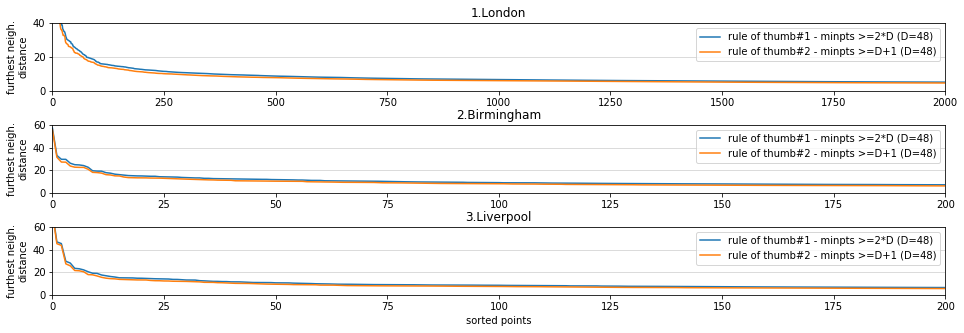

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(16, 5))
def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    ax.set_ylabel('furthest neigh.\ndistance',size=10)
    ax.legend(['rule of thumb#1 - minpts >=2*D (D=' + str(n_nbrs2) + ')'\
           ,'rule of thumb#2 - minpts >=D+1 (D=' + str(n_nbrs2) + ')'])
    
ax[0].plot(np.sort(distances1_london[:,n_nbrs1-1])[::-1])
ax[0].plot(np.sort(distances2_london[:,n_nbrs2-1])[::-1])
ax[0].set_ylim([0,40])
ax[0].set_xlim([0,2000])
ax[0].set_title('1.London');
applyPlotStyle(ax[0])
ax[1].plot(np.sort(distances1_birmingham[:,n_nbrs1-1])[::-1])
ax[1].plot(np.sort(distances2_birmingham[:,n_nbrs2-1])[::-1])
ax[1].set_ylim([0,60])
ax[1].set_xlim([0,200])
ax[1].set_title('2.Birmingham');
applyPlotStyle(ax[1])
ax[2].plot(np.sort(distances1_liverpool[:,n_nbrs1-1])[::-1])
ax[2].plot(np.sort(distances2_liverpool[:,n_nbrs2-1])[::-1])
ax[2].set_ylim([0,60])
ax[2].set_xlim([0,200])
ax[2].set_title('3.Liverpool');
ax[2].set_xlabel('sorted points',size=10)
applyPlotStyle(ax[2])
plt.subplots_adjust(hspace=0.5)

In [21]:
np.percentile(distances2_birmingham[:,n_nbrs2-1],99)

12.74195363875847

#### check "meaningful values" that could potentionally mark the lower part of the "knee"
    
    np.percentile(distances2_london[:,n_nbrs2-1],99.50)
    
"rule of thumb#2" looks a bit smoother -> density connection of points is more continuous than "rule of thumb#2" -> number of outliers should be a function of eps.  
Eps value ranges per city:  
London: 3(\~p80) - 10 (\~p99)  
Birmingham: 5(\~p80) - 14 (\~p99)  
Liverpool: 5(\~p80) - 14 (\~p99)  

### 4.2.2 DBSCAN computation
Example for London (computed aso for Birmingham and Liverpool)

In [ ]:
dbscan_results_list = list()
temp = list()
eps_list = [3,4,5,6,7,8,9,10,11,12,13]
min_samples_list = [49,96]
for min_samples in min_samples_list:
    for eps in eps_list:
        temp = list()
        dbscan_clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(london_vdt_samples)
        temp.append(str(eps))
        temp.append(str(min_samples))
        temp.append(dbscan_clusterer.labels_)
        dbscan_results_list.append(temp)
dbscan_results_pd = pd.DataFrame(dbscan_results_list, columns=['eps','min_samples','labels'])

# maybe there is a better way how to put arrays ('outliers') into pandas cells...
temp_clusters = list()
temp_num_outliers = list()
temp_outliers = list()

for labels in dbscan_results_pd['labels']:
    temp_clusters.append(len(np.unique(labels)))
    temp_num_outliers.append(len(np.where(labels == -1)[0]))
    temp_outliers.append(np.where(labels == -1)[0])
    
dbscan_results_pd['#clusters'] = temp_clusters
dbscan_results_pd['#outliers'] = temp_num_outliers
dbscan_results_pd['outliers'] = temp_outliers
dbscan_results_pd.to_pickle('datasets/DBSCAN_results/vdt_dbscan_outliers_london.csv')

In [2]:
london_dbscan_results_pd = pd.read_pickle('datasets/DBSCAN_results/vdt_dbscan_outliers_london.csv')
birmingham_dbscan_results_pd = pd.read_pickle('datasets/DBSCAN_results/vdt_dbscan_outliers_birmingham.csv')
liverpool_dbscan_results_pd = pd.read_pickle('datasets/DBSCAN_results/vdt_dbscan_outliers_liverpool.csv')

### 4.2.3 DBSCAN results analysis

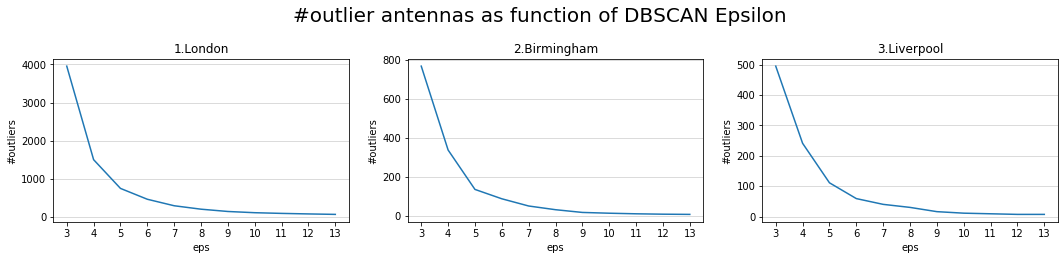

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), facecolor='w', edgecolor='k')
fig.suptitle('#outlier antennas as function of DBSCAN Epsilon', size=20, y=1.12)

def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    #ax.set_ylim([0,0.55])
    ax.set_xlabel('eps')
    ax.set_ylabel('#outliers')
    
x = london_dbscan_results_pd[london_dbscan_results_pd.min_samples=='49']['eps']
y = london_dbscan_results_pd[london_dbscan_results_pd.min_samples=='49']['#outliers']
ax[0].plot(x,y)
applyPlotStyle(ax[0])
ax[0].set_title('1.London')

x = birmingham_dbscan_results_pd[birmingham_dbscan_results_pd.min_samples=='49']['eps']
y = birmingham_dbscan_results_pd[birmingham_dbscan_results_pd.min_samples=='49']['#outliers']
ax[1].plot(x,y)
applyPlotStyle(ax[1])
ax[1].set_title('2.Birmingham')

x = liverpool_dbscan_results_pd[liverpool_dbscan_results_pd.min_samples=='49']['eps']
y = liverpool_dbscan_results_pd[liverpool_dbscan_results_pd.min_samples=='49']['#outliers']
ax[2].plot(x,y)
applyPlotStyle(ax[2])
ax[2].set_title('3.Liverpool');

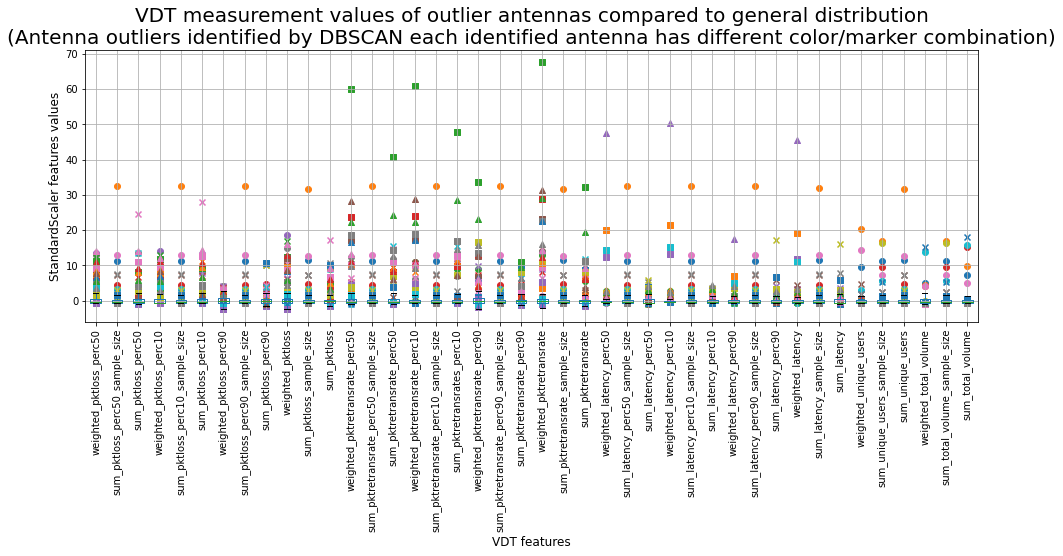

In [141]:
from matplotlib.cm import get_cmap
# list of colormapshttps://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
cmap = get_cmap('tab10')  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.set_title('VDT measurement values of outlier antennas compared to general distribution\n(Antenna outliers identified by DBSCAN each identified antenna has different color/marker combination)',size=20)

outlier_indexes = london_dbscan_results_pd[(london_dbscan_results_pd.min_samples=='43') & (london_dbscan_results_pd.eps=='10')]['outliers'].values[0]

london_vdt_pd_ml_scaled.drop(columns='IMDDecil').boxplot(rot=90, showfliers = False)

#ax.set_xticklabels(boxplot_dataset.columns.values,fontsize=12, rotation=90)
ax.set_xlabel('VDT features', size=12)
ax.set_ylabel('StandardScaler features values', size=12)

x_points = range(1, len(london_vdt_pd_ml_scaled.drop(columns='IMDDecil').columns)+1)
markers = ['o','x','s','^']
for outlier,i in zip(outlier_indexes,range(len(outlier_indexes))):
    marker = markers[i//10]
    color = colors[np.mod(i,10)]
    ax.scatter(x_points,london_vdt_pd_ml_scaled.drop(columns='IMDDecil').iloc[outlier].values,color=color, marker=marker);

In [7]:
london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
birmingham_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_imd_pd.csv'
liverpool_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_imd_pd.csv'

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)
birmingham_antenna_imd_pd = pd.read_csv(birmingham_antenna_imd_loc, index_col=False)
liverpool_antenna_imd_pd = pd.read_csv(liverpool_antenna_imd_loc, index_col=False)

In [8]:
# indexes of identifeid outliers - eps values chosen from the end of the DBCAN calculation when the #outliers is not changing anymore
outlier_indexes_london = london_dbscan_results_pd[(london_dbscan_results_pd.min_samples=='49') & (london_dbscan_results_pd.eps=='12')]['outliers'].values[0]
outlier_indexes_birmingham = birmingham_dbscan_results_pd[(birmingham_dbscan_results_pd.min_samples=='49') & (birmingham_dbscan_results_pd.eps=='12')]['outliers'].values[0]
outlier_indexes_liverpool = liverpool_dbscan_results_pd[(liverpool_dbscan_results_pd.min_samples=='49') & (liverpool_dbscan_results_pd.eps=='12')]['outliers'].values[0]

# I removed the 'lkey' information at the beginning so I need to reload these datasets
london_vdt_pd = pd.read_csv(london_vdt_loc, index_col=False)
birmingham_vdt_pd = pd.read_csv(birmingham_vdt_loc, index_col=False)
liverpool_vdt_pd = pd.read_csv(liverpool_vdt_loc, index_col=False)

london_vdt_pd = london_vdt_pd.drop(columns=['day']).dropna().groupby('lkey', as_index=False).mean()
birmingham_vdt_pd = birmingham_vdt_pd.drop(columns=['day']).dropna().groupby('lkey', as_index=False).mean()
liverpool_vdt_pd = liverpool_vdt_pd.drop(columns=['day']).dropna().groupby('lkey', as_index=False).mean()

# I need this for IMDDecil information
london_vdt_pd = london_vdt_pd.merge(london_antenna_imd_pd, on='lkey', how='inner').drop(columns=['generation', 'geometry', 'geometry_voronoi']).dropna()
birmingham_vdt_pd = birmingham_vdt_pd.merge(birmingham_antenna_imd_pd, on='lkey', how='inner').drop(columns=['generation', 'geometry', 'geometry_voronoi']).dropna()
liverpool_vdt_pd = liverpool_vdt_pd.merge(liverpool_antenna_imd_pd, on='lkey', how='inner').drop(columns=['generation','geometry', 'geometry_voronoi']).dropna()

# I need this for geo information and I am lazy to recreate the geo information from previous _vdt_pd dataframes
telefonica_antenna_london_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_london_gpd.geojson')
telefonica_antenna_birmingham_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_birmingham_gpd.geojson')
telefonica_antenna_liverpool_gpd = gpd.read_file('datasets/Telefonica_Antenna/XG/telefonica_antenna_liverpool_gpd.geojson')

outlier_telefonica_antenna_london_gpd = telefonica_antenna_london_gpd.merge(london_vdt_pd.iloc[outlier_indexes_london], on='lkey', how='inner')
outlier_telefonica_antenna_birmingham_gpd = telefonica_antenna_birmingham_gpd.merge(birmingham_vdt_pd.iloc[outlier_indexes_birmingham], on='lkey', how='inner')
outlier_telefonica_antenna_liverpool_gpd = telefonica_antenna_liverpool_gpd.merge(liverpool_vdt_pd.iloc[outlier_indexes_liverpool], on='lkey', how='inner')

In [9]:
london_lsoa_2019_boundary_gpd = gpd.read_file('datasets/UK_LSOA/london_lsoa_2019_boundary.geojson')
birmingham_lsoa_2019_boundary_gpd = gpd.read_file('datasets/UK_LSOA/birmingham_lsoa_2019_boundary.geojson')
liverpool_lsoa_2019_boundary_gpd = gpd.read_file('datasets/UK_LSOA/liverpool_lsoa_2019_boundary.geojson')

In [15]:
from shapely.geometry import Polygon

C:\ProgramData\Anaconda3\lib\site-packages\contextily\tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


Number of outlier antennas within red square: 28


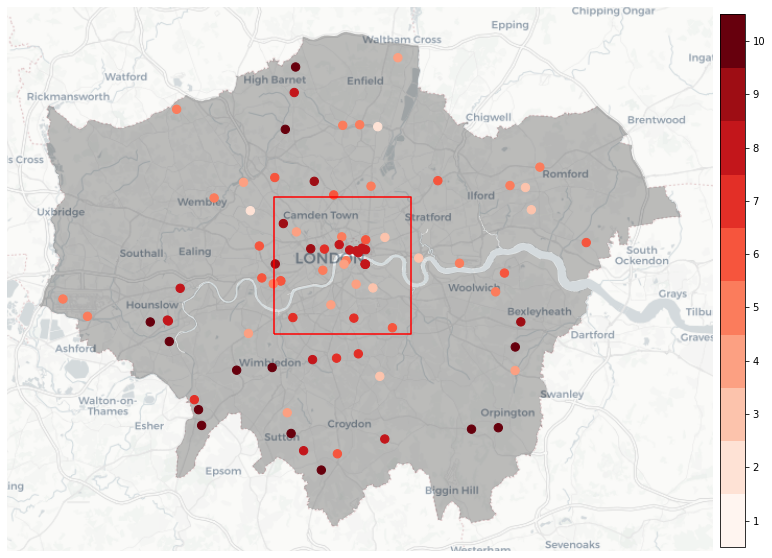

In [54]:
# size of the red box
box_size = 10000

def add_basemap(ax, zoom, url="http://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY.png"):#url='http://tile.stamen.com/toner/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

#plot LSOAs with IMD deciles represented by shades of grey
fig, ax = plt.subplots(figsize=(18,10), facecolor='w', edgecolor='k')
#fig.suptitle('Outlier antennas locations, intesity of color shows IMD decile of antenna', size=20, y=0.85)

color = cmap=plt.cm.get_cmap('binary', 10)

#ax = plt.subplot(1,3,1)
ax = plt.subplot(1,1,1)
#plt.title('1. London',fontsize=12)
boundary = london_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black')
colors = outlier_telefonica_antenna_london_gpd['IMDDecil'].map(plt.cm.get_cmap('Reds', 10)).values
points = outlier_telefonica_antenna_london_gpd.plot(ax=ax,alpha = 1,color=colors, markersize=70)
add_basemap(ax, zoom=10)
ax.set_axis_off()
polygon = Polygon([(-12365.503-box_size,6710374.586-box_size), (-12365.503-box_size,6710374.586+box_size), (-12365.503+box_size,6710374.586+box_size), (-12365.503+box_size,6710374.586-box_size)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=outlier_telefonica_antenna_london_gpd.crs)
poly_gdf.boundary.plot(ax=ax, color="red")
print('Number of outlier antennas within red square: ' + str(len(outlier_telefonica_antenna_london_gpd[outlier_telefonica_antenna_london_gpd.geometry.within(poly_gdf.geometry.unary_union)])))
fig.savefig('plots/dbsan_outlier_antennas_london.pdf',transparent=True,bbox_inches='tight', pad_inches=0, frameon=False);

# ax = plt.subplot(1,3,2)
# plt.title('2. Birmingham',fontsize=12)
# boundary = birmingham_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black')
# colors = outlier_telefonica_antenna_birmingham_gpd['IMDDecil'].map(plt.cm.get_cmap('Reds', 10)).values
# points = outlier_telefonica_antenna_birmingham_gpd.plot(ax=ax,alpha = 1,color=colors, markersize=30)
# add_basemap(ax, zoom=10)
# ax.set_axis_off()

# ax = plt.subplot(1,3,3)
# plt.title('3. Liverpool',fontsize=12)
# boundary = liverpool_lsoa_2019_boundary_gpd.plot(ax=ax,alpha = 0.25, color='black',edgecolor='black')
# colors = outlier_telefonica_antenna_liverpool_gpd['IMDDecil'].map(plt.cm.get_cmap('Reds', 10)).values
# points = outlier_telefonica_antenna_liverpool_gpd.plot(ax=ax,alpha = 1,color=colors, markersize=30)
# add_basemap(ax, zoom=10)
# ax.set_axis_off()

# I had to create custom color bar as the image/picture does not contain all IMD deciles
# code adjusted from https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
cmap = plt.cm.get_cmap('Reds', 10)
bounds = np.linspace(1, 11, 11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ticks = bounds-0.5
# for all 3 plots
#ax_cbar = fig.add_axes([0.92, 0.23, 0.02, 0.55])
ax_cbar = fig.add_axes([0.79, 0.13, 0.02, 0.74])
cbar = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap, norm=norm, spacing='proportional', ticks=ticks, boundaries=bounds)#, format='%1i')
cbar.set_ticklabels(bounds.astype(int).astype(str))

# 5. APPENDIX - check similarity between previous(Feb - Mar 2019) and current VDT dataset for London

Only weighted_total_volume stands out. Previously it was ~10 now it's ~50.

In [105]:
london_antenna_imd_loc = 'datasets/Telefonica_Antenna/XG/telefonica_antenna_london_imd_pd.csv'
london_vdt_loc = 'datasets/VDT/newvdt202002_london.csv'
london_vdt_prev_loc = 'datasets/VDT/AntennaMLDataset_FebMar_df_2019.csv'

london_antenna_imd_pd = pd.read_csv(london_antenna_imd_loc, index_col=False)

london_vdt_pd = pd.read_csv(london_vdt_loc, index_col=False).dropna().drop(columns=['day'])
london_vdt_pd = london_vdt_pd.groupby('lkey', as_index=False).mean()
london_vdt_pd = london_vdt_pd.merge(london_antenna_imd_pd, on='lkey', how='inner').drop(columns=['lkey','generation', 'geometry', 'geometry_voronoi']).dropna()

additional_prev_columns = [ 'lkey', '1_imd_avgctime', '1_imd_avgdevcnt', '2_imd_avgctime',\
                           '2_imd_avgdevcnt', '3_imd_avgctime', '3_imd_avgdevcnt',\
                           '4_imd_avgctime', '4_imd_avgdevcnt', '5_imd_avgctime',\
                           '5_imd_avgdevcnt', '6_imd_avgctime', '6_imd_avgdevcnt',\
                           '7_imd_avgctime', '7_imd_avgdevcnt', '8_imd_avgctime',\
                           '8_imd_avgdevcnt', '9_imd_avgctime', '9_imd_avgdevcnt',\
                           '10_imd_avgctime', '10_imd_avgdevcnt',]
london_vdt_prev_pd = pd.read_csv(london_vdt_prev_loc, index_col=False).dropna().drop(columns=additional_prev_columns)
london_vdt_prev_pd.rename(columns={'LSOA_IMD_decile': 'IMDDecil'}, inplace=True)

## 5.1 Columns comparisson

In [114]:
print('List of same columns in both datasets')
prev_columns = list(set(london_vdt_prev_pd.columns).intersection(london_vdt_pd.columns))
set(london_vdt_prev_pd.columns).intersection(london_vdt_pd.columns)

List of same columns in both datasets


{'IMDDecil',
 'weighted_latency',
 'weighted_latency_perc10',
 'weighted_latency_perc50',
 'weighted_latency_perc90',
 'weighted_pktloss',
 'weighted_pktloss_perc10',
 'weighted_pktloss_perc50',
 'weighted_pktloss_perc90',
 'weighted_pktretransrate',
 'weighted_pktretransrate_perc10',
 'weighted_pktretransrate_perc50',
 'weighted_pktretransrate_perc90',
 'weighted_total_volume'}

In [113]:
print('List of new columns in new datasets')
set(london_vdt_pd.columns).difference(london_vdt_prev_pd.columns)

List of new columns in new datasets


['sum_latency_perc10_sample_size',
 'sum_latency_perc50_sample_size',
 'weighted_unique_users',
 'sum_pktretransrate_perc50',
 'sum_pktloss_perc10',
 'sum_pktloss_sample_size',
 'sum_pktretransrate_perc10_sample_size',
 'sum_total_volume_sample_size',
 'sum_total_volume',
 'sum_pktloss_perc90',
 'sum_pktretransrate_sample_size',
 'sum_pktloss_perc10_sample_size',
 'sum_pktretransrates_perc10',
 'sum_pktloss_perc90_sample_size',
 'sum_unique_users_sample_size',
 'sum_latency_perc10',
 'sum_pktretransrate_perc90_sample_size',
 'sum_latency_perc90',
 'sum_pktretransrate_perc90',
 'sum_latency',
 'sum_latency_perc50',
 'sum_unique_users',
 'sum_pktloss_perc50',
 'sum_pktloss_perc50_sample_size',
 'sum_pktretransrate_perc50_sample_size',
 'sum_pktloss',
 'sum_latency_sample_size',
 'sum_pktretransrate',
 'sum_latency_perc90_sample_size']

## 5.2 Dataset and IMD Decile classes size comparisson

In [156]:
print('Sizes of the datasets (PREV vs NEW):\n' + str(len(london_vdt_prev_pd)) + ' : ' + str(len(london_vdt_pd)))

Sizes of the datasets (PREV vs NEW):
34249 : 32892


Text(0.5, 1.0, 'NEW London')

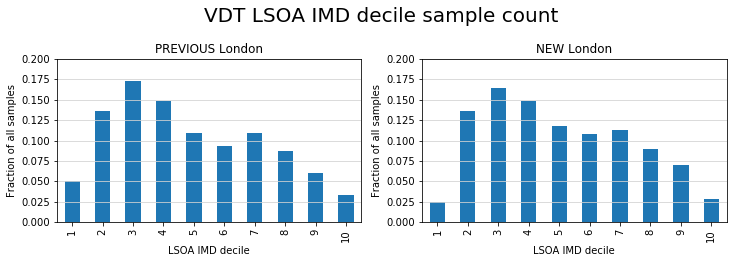

In [206]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), facecolor='w', edgecolor='k')
fig.suptitle('VDT LSOA IMD decile sample count', size=20, y=1.12)

def applyPlotStyle(ax):
    ax.yaxis.grid(True, linestyle='-', which='both', color='lightgrey')
    ax.set_ylim([0,0.2])
    ax.set_xlabel('LSOA IMD decile')
    ax.set_ylabel('Fraction of all samples')
    
london_vdt_prev_pd['IMDDecil'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax[0])
applyPlotStyle(ax[0])
ax[0].set_title('PREVIOUS London')

london_vdt_pd['IMDDecil'].value_counts(sort=False,normalize=True).sort_index().plot(kind='bar',ax=ax[1])
applyPlotStyle(ax[1])
ax[1].set_title('NEW London')

## 5.3 Distribution of values comparisson

/home/big-dama/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


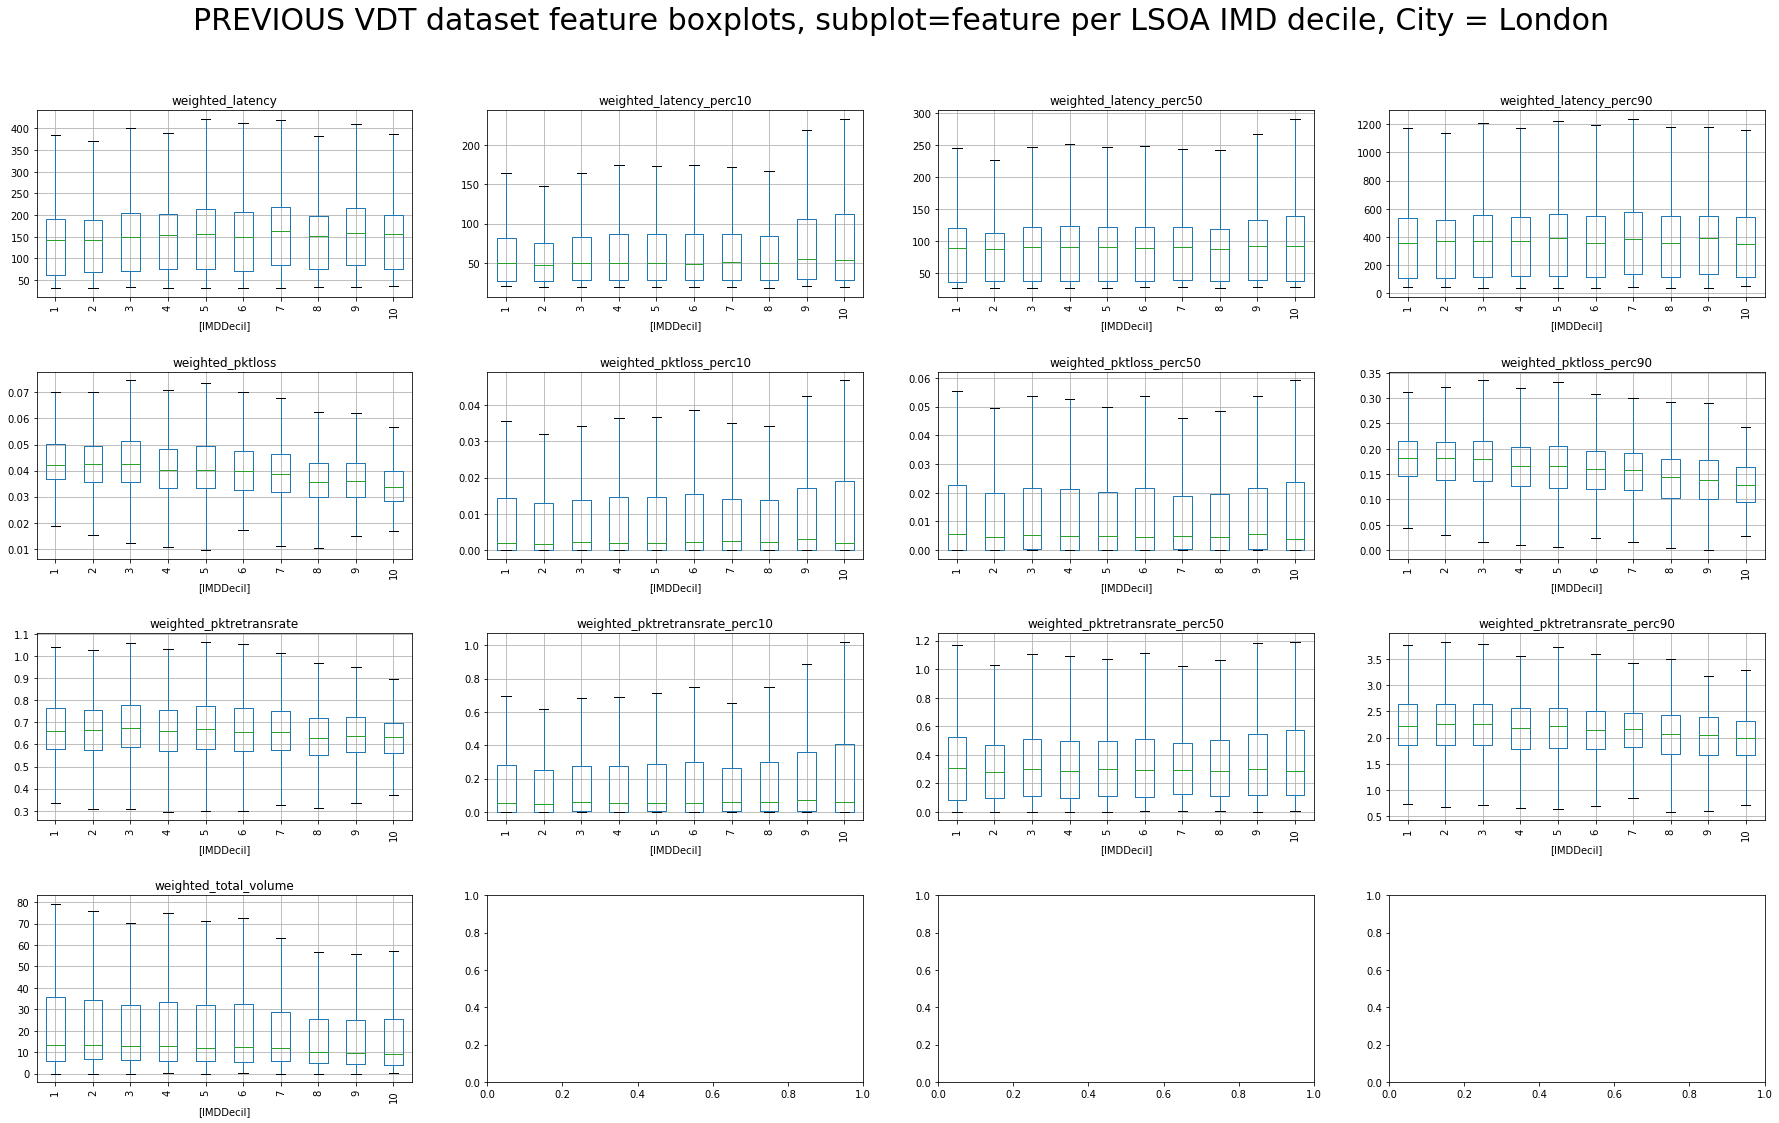

In [152]:
# it's f*cked up, but I have to pass exact number of ax to boxplot otherwise I am unable 
# to have separate y-axis for each subplot
fig, ax = plt.subplots(4,4, figsize=(30, 18),sharey=False)
ax = np.delete(ax.flatten(), [13,14,15])
london_vdt_prev_pd[prev_columns].boxplot(ax=ax, by='IMDDecil', rot=90, showfliers=False)
fig.suptitle('PREVIOUS VDT dataset feature boxplots, subplot=feature per LSOA IMD decile, City = London', size=30)#
plt.subplots_adjust(hspace = 0.4);

/home/big-dama/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


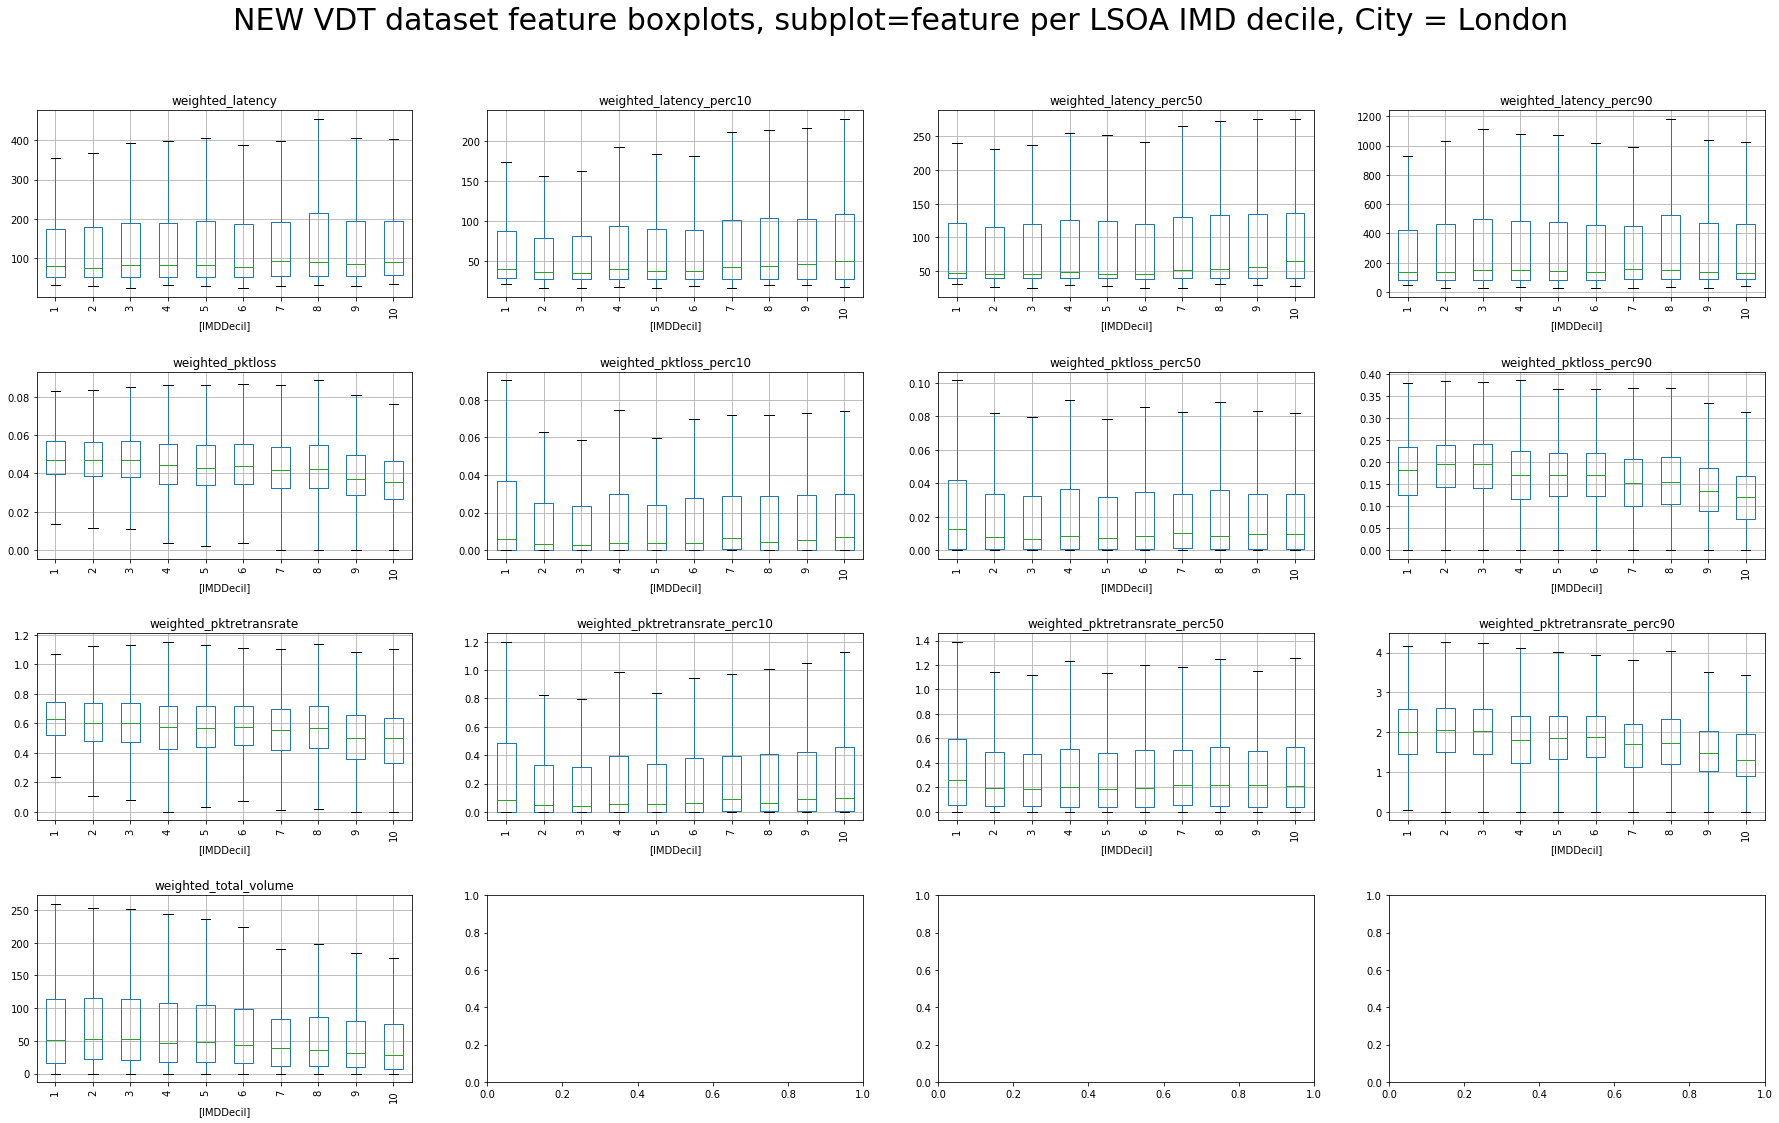

In [151]:
# it's f*cked up, but I have to pass exact number of ax to boxplot otherwise I am unable 
# to have separate y-axis for each subplot
fig, ax = plt.subplots(4,4, figsize=(30, 18),sharey=False)
ax = np.delete(ax.flatten(), [13,14,15])
london_vdt_pd[prev_columns].boxplot(ax=ax, by='IMDDecil', rot=90, showfliers=False)
fig.suptitle('NEW VDT dataset feature boxplots, subplot=feature per LSOA IMD decile, City = London', size=30)#
plt.subplots_adjust(hspace = 0.4);